In [1]:
import os
import tqdm

import torch
from torch import nn as nn

import numpy as np
import skimage as ski

import matplotlib.pyplot as plt
from utils import *

In [2]:
class GaussianMixture:
    def __init__(self, k=3, dim=2):
        self.dim = 2
        
        radius = 10
        thetas = torch.arange(k) * 2 * np.pi / k
        self.mus = radius * torch.hstack([torch.cos(thetas)[:, None], torch.sin(thetas)[:, None]])
        self.sigmas = torch.stack([2 * torch.rand(self.dim) for _ in range(k)])
        
        temp = torch.rand(k)
        self.alphas = temp / temp.sum()
        self.ks = []

    def inv_sigmoid(self, value):
        return torch.log(value/(1-value))
    
    def sample(self, n):
        
        samples = torch.zeros((n, self.dim))
        for i in range(n):
            # sample uniform
            r = torch.rand(1).item()
            # select gaussian
            k = 0
            for j, threshold in enumerate(self.alphas.cumsum(dim=0).tolist()):
                if r < threshold:
                    k = j
                    break
            self.ks.append(k)

            selected_mu = self.mus[k]
            selected_cov = self.sigmas[k] * torch.eye(2)

            # sample from selected gaussian
            lambda_, gamma_ = torch.linalg.eig(selected_cov)
            lambda_ = lambda_.real
            gamma_ = gamma_.real

            dimensions = len(lambda_)
            # sampling from normal distribution
            y_s = torch.rand((dimensions * 1, 3))
            x_normal = torch.mean(self.inv_sigmoid(y_s), axis=1).reshape((-1, dimensions))
            # transforming into multivariate distribution
            samples[i] = (x_normal * lambda_) @ gamma_ + selected_mu
            
        return samples

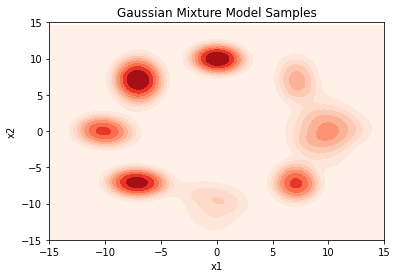

In [3]:
# sample some data and plot the density
np.random.seed(0)
gmm = GaussianMixture(k=8)
samples = gmm.sample(1000)
plot_density_from_samples(samples, filepath='plots/1-samples.png', show=True, save=True)

In [11]:
# we will learn the distribution from VAE

import torch.nn.functional as F
from torch import nn

class HalfBlock(nn.Module):
    def __init__(self,inp_dim):
        super().__init__()
        self.batchnorm = nn.BatchNorm1d(inp_dim)
        self.dropout = nn.Dropout1d(0.1)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(inp_dim,inp_dim)
    def forward(self,x):
        x = self.batchnorm(x)
        x = self.dropout(x)
        x = self.linear(x)
        x = self.relu(x)
        return x

class Block(nn.Module):
    def __init__(self,inp_dim):
        super().__init__()
        self.blocks = nn.ModuleList([HalfBlock(inp_dim) for _ in range(1)])
    def forward(self,x):
        for block in self.blocks:
            x = block(x)
        return x
    
class MLP(nn.Module):
    def __init__(self,inp_dim,out_dim):
        super().__init__()
        self.layers= nn.ModuleList([Block(inp_dim) for _ in range(1)])
        self.linear = nn.Linear(inp_dim,out_dim)
    def forward(self,x):
        for l in self.layers:
            x = x + l(x)
        x = self.linear(x)
        return x


model = MLP(2,8)




optimiser_phi = torch.optim.Adam(model.parameters(),0.1)
scheduler_phi = torch.optim.lr_scheduler.CosineAnnealingLR(optimiser_phi, 50, eta_min=0)


#model_mu = MLP(8,2)
#model_si = MLP(8,2)
#optimiser_theta = torch.optim.Adam(list(model_mu.parameters())+list(model_si.parameters()),0.1)
#scheduler_theta = torch.optim.lr_scheduler.CosineAnnealingLR(optimiser_theta, 1000, eta_min=0)


mu  = nn.Parameter(torch.rand((8,2)),requires_grad=True)
log_sigma  = nn.Parameter(torch.rand((8,2)),requires_grad=True)
optimiser_theta = torch.optim.Adam([mu,log_sigma],0.1)
scheduler_theta = torch.optim.lr_scheduler.CosineAnnealingLR(optimiser_theta, 100, eta_min=0)

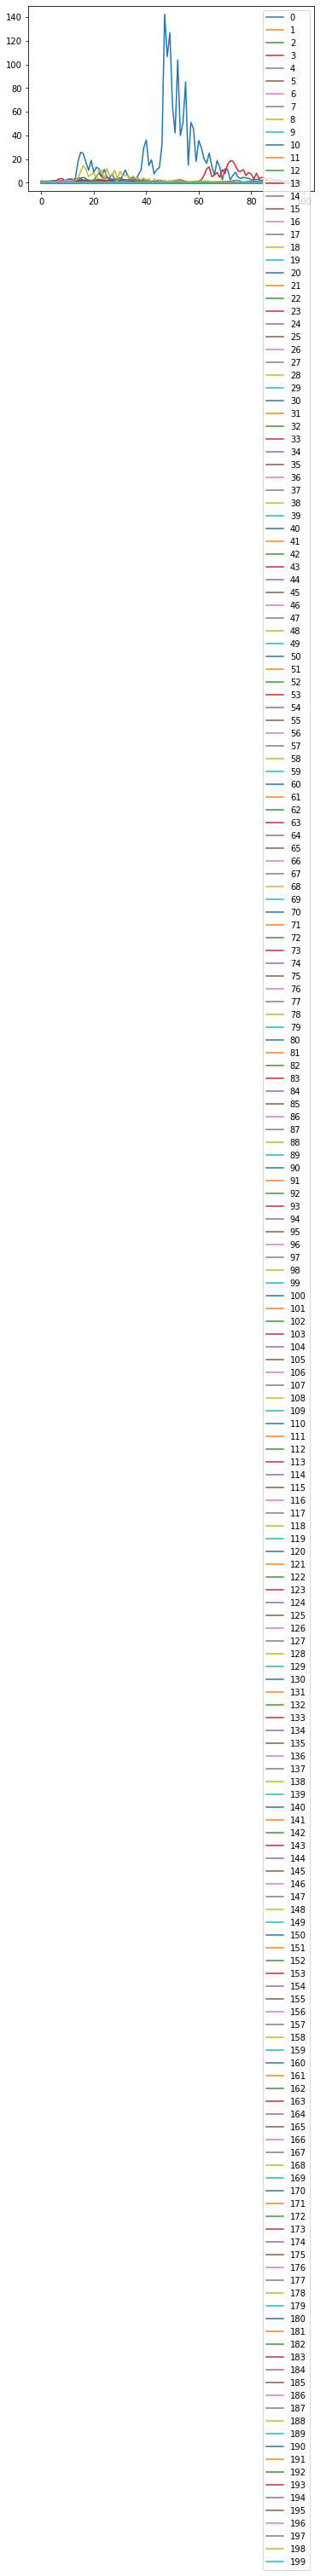

In [15]:
l = []

#model_mu.train()
#model_si.train()
model.train()
for j in range(200):

    al = []
    for i in range(100):

        logits = model(samples)
        p = F.softmax(logits,dim=-1).log()
        q = gmm.alphas
        kl_loss = F.kl_div(p,q,reduction='sum')
        loss =  kl_loss
        optimiser_phi.zero_grad()
        al.append(loss.item())
        loss.backward()
        optimiser_phi.step()
    scheduler_phi.step()
    plt.plot(al,label = j)

    
    logits = model(samples)
    reconstruction_loss = 0
    for _ in range(100):
        mode = F.gumbel_softmax(logits,dim=1,hard=False)

        m = mode @ mu
        l_s = mode @ log_sigma
        #m = model_mu(mode)
        #_s = model_si(mode)


        reconstruction_loss  += 0.5*(l_s + (samples - m)**2/l_s.exp()).sum(dim=-1).mean() # #
    

    loss =   reconstruction_loss
    optimiser_theta.zero_grad()
    loss.backward()
    optimiser_theta.step()
    scheduler_theta.step()
    l.append(loss.item())

#plt.plot(l)
plt.legend()

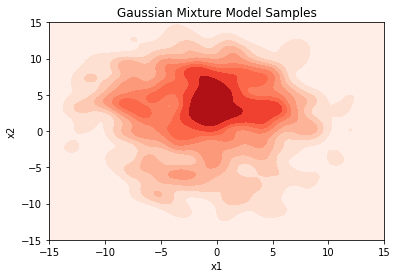

In [8]:
model_mu.eval()
model.eval()
model_si.eval()

u = []
with torch.no_grad():
    for i in range(1000):
        # sample uniform
        r = torch.rand(1).item()
        # select gaussian
        k = 0
        for j, threshold in enumerate(gmm.alphas.cumsum(dim=0).tolist()):
            if r < threshold:
                k = j
                break

        u.append(k)
        #sample x from this gaussian
u = torch.tensor(u)
u = F.one_hot(u,8)*1.0
new_samples = torch.normal(model_mu(u),model_si(u).exp()**(0.5))
plot_density_from_samples(new_samples.detach().numpy(), filepath='plots/2-samples.png', show=True, save=True)


In [13]:
list(zip(F.gumbel_softmax(logits,dim=1,hard=True).argmax(1),gmm.ks))

[(tensor(5), 3),
 (tensor(2), 5),
 (tensor(3), 0),
 (tensor(0), 6),
 (tensor(2), 4),
 (tensor(0), 7),
 (tensor(3), 7),
 (tensor(1), 5),
 (tensor(3), 5),
 (tensor(5), 7),
 (tensor(7), 2),
 (tensor(3), 3),
 (tensor(0), 5),
 (tensor(2), 3),
 (tensor(2), 0),
 (tensor(2), 5),
 (tensor(0), 4),
 (tensor(4), 7),
 (tensor(3), 4),
 (tensor(3), 1),
 (tensor(7), 0),
 (tensor(3), 6),
 (tensor(3), 2),
 (tensor(5), 0),
 (tensor(5), 0),
 (tensor(6), 7),
 (tensor(5), 6),
 (tensor(2), 0),
 (tensor(5), 5),
 (tensor(3), 1),
 (tensor(4), 5),
 (tensor(5), 1),
 (tensor(2), 0),
 (tensor(4), 7),
 (tensor(5), 4),
 (tensor(2), 6),
 (tensor(3), 5),
 (tensor(1), 4),
 (tensor(5), 3),
 (tensor(5), 0),
 (tensor(0), 0),
 (tensor(4), 4),
 (tensor(4), 1),
 (tensor(0), 5),
 (tensor(2), 4),
 (tensor(7), 7),
 (tensor(3), 2),
 (tensor(0), 5),
 (tensor(0), 7),
 (tensor(3), 0),
 (tensor(0), 4),
 (tensor(5), 1),
 (tensor(6), 0),
 (tensor(5), 2),
 (tensor(3), 2),
 (tensor(5), 3),
 (tensor(2), 5),
 (tensor(0), 3),
 (tensor(0), 3

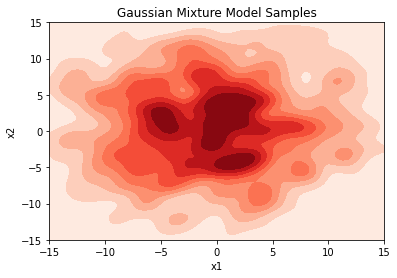

In [6]:
u = []
model.eval()

with torch.no_grad():
    for i in range(1000):
        # sample uniform
        r = torch.rand(1).item()
        # select gaussian
        k = 0
        for j, threshold in enumerate(gmm.alphas.cumsum(dim=0).tolist()):
            if r < threshold:
                k = j
                break
        u.append(k)
u = torch.tensor(u)




new_samples = torch.normal(mu[u],log_sigma[u].exp()**(0.5))
plot_density_from_samples(new_samples.detach().numpy(), filepath='plots/2-samples.png', show=True, save=True)


In [14]:
mu, log_sigma.exp()**(0.5)

(Parameter containing:
 tensor([[-0.7576,  0.7137],
         [-0.8346,  0.7085],
         [-0.6829,  0.7616],
         [-0.7390,  0.7326],
         [-0.8910,  0.7098],
         [-0.6136,  0.7394],
         [-0.8016,  0.6997],
         [-0.7704,  0.7432]], requires_grad=True),
 tensor([[7.6538, 5.6400],
         [5.6388, 6.4416],
         [6.2765, 5.7843],
         [6.6841, 7.2399],
         [7.3811, 7.3146],
         [6.7594, 7.4099],
         [6.8663, 6.3849],
         [7.0522, 6.7311]], grad_fn=<PowBackward0>))

In [88]:
F.kl_div(p,q,reduction='batchmean')

tensor(3.7886, grad_fn=<DivBackward0>)

In [61]:
log_sigma.exp()*(0.5)

tensor([[19.1826,  5.0219],
        [24.3155,  7.7036],
        [ 0.5800,  0.9936],
        [ 0.6033,  1.2681],
        [ 0.6439,  0.6883],
        [ 1.1781,  0.7881],
        [ 0.9828,  0.9295],
        [ 1.1165,  1.1678]], grad_fn=<MulBackward0>)

In [29]:
mu.weight.data

tensor([[-0.1838,  0.4472],
        [ 0.4131,  0.4773],
        [-1.0653,  1.4943],
        [-0.9067, -0.0357],
        [ 0.3550, -1.3340],
        [ 0.8884, -0.7141],
        [-1.2220, -0.2683],
        [-1.5473, -1.9082]])

In [78]:
mu

Parameter containing:
tensor([[2.0860, 0.2882],
        [2.1704, 0.2900],
        [1.9749, 0.2855],
        [2.0901, 0.2936],
        [2.1987, 0.2842],
        [2.0872, 0.2898],
        [2.1089, 0.2811],
        [2.0691, 0.2779]], requires_grad=True)